## Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Holt-Winter's Model

In [46]:
class WintersModel:
  def __init__(self, alpha, beta, gamma, s):
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
    self.s = s

  def train(self, dataset):
    self.dataset = dataset
    self.level = np.zeros(len(dataset))
    self.trend = np.zeros(len(dataset))
    self.seasonality = np.zeros(len(dataset))
    self.forecast = np.zeros(len(dataset))

    #initial values
    self.seasonality[0] = dataset[0] / sum(dataset[:self.s])
    self.level[0] = dataset[0] / self.seasonality[0]
    self.trend[0] = sum([float(dataset[i + self.s] - dataset[i]) for i in range(self.s)]) / self.s
    self.forecast[0] = dataset[0]

    #formulas
    for i in range(1, len(dataset)):
      self.seasonality[i] = dataset[i] / sum(dataset[i//self.s * self.s:(i//self.s + 1) * self.s])
      self.level[i] = self.alpha * (dataset[i] / self.seasonality[i]) + (1 - self.alpha) * (self.level[i - 1] + self.trend[i - 1])
      self.trend[i] = self.beta * (self.level[i] - self.level[i - 1]) + (1 - self.beta) * self.trend[i - 1]
      self.forecast[i] = (self.level[i - 1] + self.trend[i - 1]) * self.seasonality[i]

  #Forecasting
  def predict(self, steps):
    forcasted_values= np.zeros(steps)
    for i in range(steps):
      forcasted_values[i] = (self.level[- 1] + self.trend[- 1]) * self.seasonality[i]
    return forcasted_values

  # Mean Absolute Deviation
  def get_MAD(self):
    mad = sum([abs(self.dataset[i] - self.forecast[i]) for i in range(len(self.dataset))])
    return mad

  # Mean Squared Deviation
  def get_MSD(self):
    msd = sum([(self.dataset[i] - self.forecast[i])**2 for i in range(len(self.dataset))])
    return msd

  # Mean Percentage Deviation(MPD)
  def get_MPD(self):
    mpd = 100 * sum([abs(self.dataset[i] - self.forecast[i])/self.dataset[i] for i in range(len(self.dataset))])
    return mpd

  #Overall Evaluation
  def evaluate(self):
    evaluation = {
       'Mean Absolute Deviation(MAD)' : self.get_MAD(),
       'Mean Squared Deviation(MSD)' : self.get_MSD(),
       'Mean Percentage Deviation(MPD)' : self.get_MPD()
    }
    return evaluation

## Testing the model with the 'sales' dataset

In [48]:
dataset = pd.read_csv('/sales.csv')
dataset.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [49]:
sales = dataset['Sales'].values

model = WintersModel( alpha=0.2, beta=0.3, gamma=0.002, s= 4)
model.train(dataset= sales)
forecasted_values = model.predict(steps = 15)


details_df = pd.DataFrame({
    'Data': sales,
    'Level': model.level,
    'Seasonality': model.seasonality,
    'Trend': model.trend,
    'Forecast': model.forecast
})


print(details_df)



     Data        Level  Seasonality       Trend    Forecast
0   266.0   714.300000     0.372393   22.700000  266.000000
1   145.9   732.460000     0.204256   21.338000  150.536609
2   183.1   745.898400     0.256335   18.968120  193.224715
3   119.3   754.753216     0.167017   15.934129  127.745451
4   180.3   777.569876     0.223947   17.998888  172.593378
5   168.5   797.475011     0.209291   18.570762  166.505200
6   231.8   813.856619     0.287915   17.914016  234.951447
7   224.5   826.436508     0.278847   16.313778  231.937036
8   192.8   841.820228     0.230044   16.034761  193.869771
9   122.9   853.903991     0.146641   14.849461  125.796896
10  336.5   862.622762     0.401503   13.010254  348.807465
11  185.9   868.126413     0.221811   10.758273  194.225245
12  194.3   868.547749     0.234889    7.657192  206.440153
13  149.5   866.403953     0.180730    4.716896  158.356672
14  210.1   862.336679     0.253989    2.081645  221.255428
15  273.3   856.974659     0.330392   -0

## Model Evaluation

In [51]:
evaluation = model.evaluate()
print(evaluation)

{'Mean Absolute Deviation(MAD)': 735.7862503542527, 'Mean Squared Deviation(MSD)': 33525.66293656346, 'Mean Percentage Deviation(MPD)': 222.13215207605376}


## Ploting Results

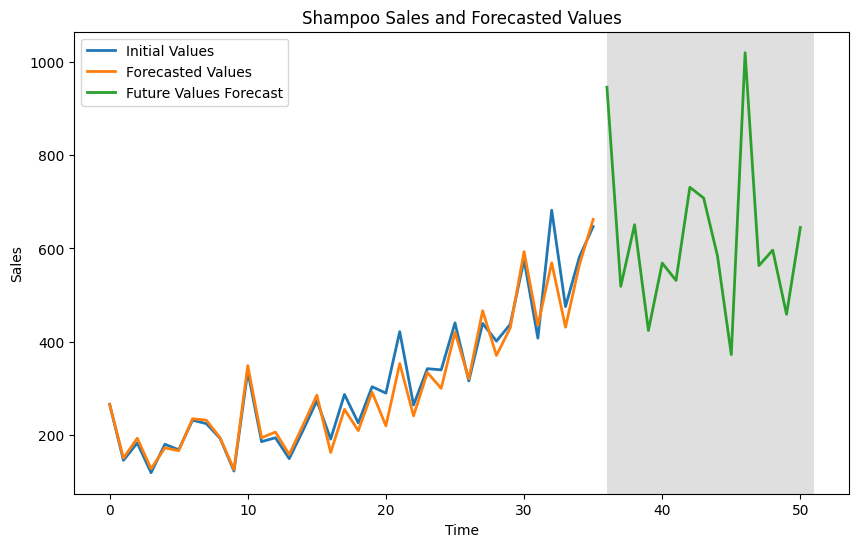

In [50]:
def plot_forecast(data, forecast):
    plt.figure(figsize=(10, 6))
    plt.plot(data, linewidth=2, label='Initial Values')
    plt.plot(model.forecast, linewidth=2, label='Forecasted Values')
    plt.plot(range(len(data), len(data) + len(forecast)), forecast, linewidth=2, label='Future Values Forecast')

    # Highlight future period
    plt.axvspan(len(data), len(data) + len(forecast), facecolor='grey', alpha=0.25)

    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.title('Shampoo Sales and Forecasted Values')
    plt.legend()
    plt.show()


plot_forecast(sales, forecasted_values)

##Linear Interpolation

In [ ]:
class Interpolate:
    def _init_(self, x_list, y_list):
        if any(y - x <= 0 for x, y in zip(x_list, x_list[1:])):
            raise ValueError("x_list must be in strictly ascending order!")
        self.x_list = x_list
        self.y_list = y_list
        intervals = zip(x_list, x_list[1:], y_list, y_list[1:])
        self.slopes = [(y2 - y1) / (x2 - x1) for x1, x2, y1, y2 in intervals]

    def _call_(self, x):
        if not (self.x_list[0] <= x <= self.x_list[-1]):
            raise ValueError("x out of bounds!")
        if x == self.x_list[-1]:
            return self.y_list[-1]
        i = bisect_right(self.x_list, x) - 1
        return self.y_list[i] + self.slopes[i] * (x - self.x_list[i])